In [0]:
!kill -9 -1

In [1]:

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free:"  + humanize.naturalsize( psutil.virtual_memory().available ), 'I Proc size:'  + humanize.naturalsize( process.memory_info().rss))
 print('GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /content/.cache/pip/wheels/ff/24/c1/7e98d678e5be90c88cc151f1f3ef77a96ea3e8266b1aa225a4
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /content/.cache/pip/wheels/d4/80/38/cfbfd95752f71f3812505b948b43383ddc99eedf835fc13b09
Successfully built humanize


FileNotFoundError: ignored

In [11]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [13]:
ls

datalab/  drive/


In [14]:
import tensorflow as tf
from keras import backend as K
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))
limit_mem()


SystemError: ignored

In [0]:
import numpy as np
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Model,model_from_json
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras
from keras.optimizers import SGD

In [0]:
np.random.seed(3)
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        k = len(self.losses)
        if(k!=0):
            self.losses.append((logs.get('loss')+self.losses[k-1]*k)/(k+1))
        else:
            self.losses.append(logs.get('loss'))


DATA_DIR = "/content/drive/DL/small"

In [27]:
train_datagen = ImageDataGenerator().flow_from_directory(directory=DATA_DIR+"//"+"train",target_size=(299,299),color_mode='rgb',
                                                         classes=["AK","FR","Noise","SGV", "SK","SM", "SP"],class_mode="categorical", batch_size=32)

Found 14387 images belonging to 7 classes.


In [28]:
val_datagen = ImageDataGenerator().flow_from_directory(directory=DATA_DIR+"//"+"val",target_size=(299,299),color_mode='rgb',
                                                       classes=["AK","FR","Noise","SGV", "SK","SM", "SP"], class_mode="categorical",batch_size=32)
test_datagen = ImageDataGenerator().flow_from_directory(directory=DATA_DIR+"//"+"test",target_size=(299,299),color_mode='rgb',
                                                        classes=["AK","FR","Noise","SGV", "SK","SM", "SP"], class_mode="categorical",batch_size=32)

Found 1780 images belonging to 7 classes.
Found 1811 images belonging to 7 classes.


In [0]:

base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [30]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [31]:
print(len(model.layers))
print(model.layers[12])

315


In [32]:
model.compile(optimizer=SGD(lr=0.001, momentum=0.9),metrics=['accuracy'], loss='categorical_crossentropy')
history = LossHistory()

# train the model on the new data for a few batches

loss_acc = model.fit_generator(generator=train_datagen,validation_data=val_datagen,epochs=5,callbacks=[history])

Epoch 1/5
450/450 [==============================] - 643s 1s/step - loss: 0.1826 - acc: 0.9553 - val_loss: 0.0059 - val_acc: 0.9989
Epoch 2/5
263/450 [================>.............] - ETA: 4:10 - loss: 0.0227 - acc: 0.9962450/450 [==============================] - 631s 1s/step - loss: 0.0206 - acc: 0.9965 - val_loss: 0.0026 - val_acc: 0.9989
Epoch 3/5
397/450 [=========================>....] - ETA: 1:11 - loss: 0.0112 - acc: 0.9986450/450 [==============================] - 632s 1s/step - loss: 0.0109 - acc: 0.9985 - val_loss: 0.0029 - val_acc: 0.9989
Epoch 4/5
448/450 [============================>.] - ETA: 2s - loss: 0.0065 - acc: 0.9994450/450 [==============================] - 630s 1s/step - loss: 0.0065 - acc: 0.9994 - val_loss: 0.0030 - val_acc: 0.9994
Epoch 5/5
450/450 [==============================] - 630s 1s/step - loss: 0.0052 - acc: 0.9995 - val_loss: 0.0040 - val_acc: 0.9994


In [33]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [34]:
model_json = model.to_json()
with open("/content/drive/DL/model_inception.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/DL/model_inception.h5")
print("Saved model to disk")


Saved model to disk


In [37]:
json_file = open('/content/drive/DL/model_inception.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/DL/model_inception.h5")
print("Loaded model from disk")


loaded_model.compile(optimizer=SGD(lr=0.001, momentum=0.9), metrics=['accuracy'],loss='categorical_crossentropy')

preds = loaded_model.evaluate_generator(test_datagen)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Loaded model from disk
Loss = 0.00014179094548931193
Test Accuracy = 1.0


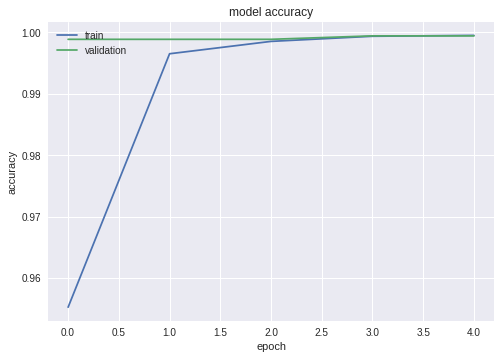

In [38]:
#summarize history for accuracy
plt.plot(loss_acc.history['acc'])
plt.plot(loss_acc.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

<function matplotlib.pyplot.show>

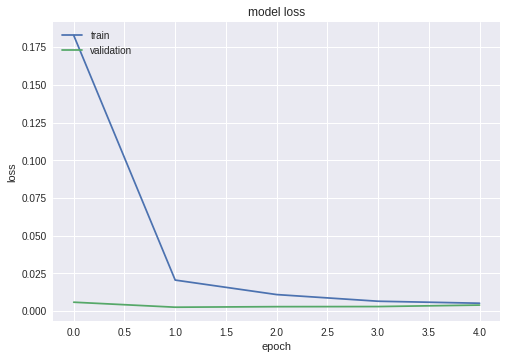

In [39]:
plt.plot(loss_acc.history['loss'])
plt.plot(loss_acc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show

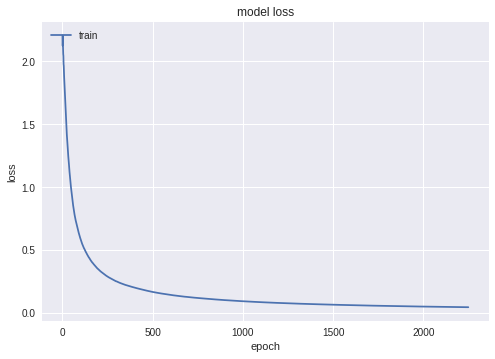

In [40]:
plt.plot(history.losses)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()